# installation

In [8]:
# !python -m pip install tensorflow==2.0.0-beta0 
!conda install -y -q seaborn


Solving environment: ...working... done

# All requested packages already installed.

2.0.0-beta0


# Imports

In [317]:
import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt
import seaborn as sns
print(sns.__version__)
import numpy as np
print(np.__version__)
keras = tf.keras

K = keras.backend


2.0.0-beta0
0.9.0
1.17.2


# Configurations

In [372]:
batch_size = 512
epochs = 2
noise_dim = 100

# datasets

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


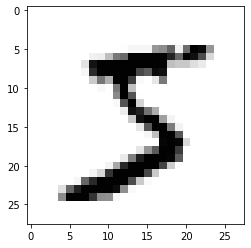

(60000, 28, 28, 1)
<PrefetchDataset shapes: (None, 28, 28, 1), types: tf.float32>


In [428]:
dataset = keras.datasets.mnist.load_data()

X_train, X_test = dataset[0][0], dataset[1][0]
Y_train, Y_test = dataset[0][1], dataset[1][1]

del(dataset)

print(X_train.shape)
print(X_test.shape)

print(Y_train.shape)
print(Y_test.shape)

plt.imshow(X_train[0], cmap="Greys")
plt.show()

X_train = X_train.reshape([*X_train.shape] + [1]).astype('float32')
X_test = X_test.reshape([*X_test.shape] + [1]).astype('float32')
print(X_train.shape)

X_train = (X_train - 127.5) / 127.5
X_test = (X_test - 127.5) / 127.5

data = tf.data.Dataset.from_tensor_slices(X_train)

data = data.shuffle(batch_size * 10).batch(batch_size).prefetch(batch_size * 5)
print(data)

# DECONVOLUTION MODEL (GENERATOR)

- INPUT : a random noise with dimension of (100,)
- OUTPUT : generated image with dimension of (28, 28, 1)


In [381]:
def build_generator():
    
    model = keras.models.Sequential()
    
    layers_kwargs = {
        'kernel_initializer': keras.initializers.TruncatedNormal(seed=0),
        'activation': 'relu',

    }
    
    model.add(keras.layers.Dense(units=256*7*7, input_shape=(100,), **layers_kwargs))
    model.add(keras.layers.Reshape(target_shape=[7, 7, 256]))
    
    layers_kwargs['padding'] = 'same'
    
    model.add(keras.layers.Conv2DTranspose(filters=128, kernel_size=(5, 5),
                                          strides=(1, 1), **layers_kwargs))
    model.add(keras.layers.Conv2DTranspose(filters=64, kernel_size=(5, 5),
                                          strides=(1, 1), **layers_kwargs))
    model.add(keras.layers.Conv2DTranspose(filters=32, kernel_size=(5, 5),
                                          strides=(2, 2), **layers_kwargs))

    layers_kwargs['activation'] = 'tanh'
    
    model.add(keras.layers.Conv2DTranspose(filters=1, kernel_size=(5, 5),
                                          strides=(2, 2), **layers_kwargs))
    
    return model

# DISCRIMINATOR MODEL

- INPUT : a image with 28x28x1 size.
- OUTPUT : the probability whether the image is fake or real

In [382]:
def build_discriminator():
    
    model = keras.models.Sequential()
    
    layers_kwargs = {
        'kernel_size': (5, 5),
        'strides': (2, 2),
        'padding': 'same',
        'activation': 'relu',
        'kernel_initializer': keras.initializers.TruncatedNormal()
    }
    
    model.add(keras.layers.Conv2D(filters=64, input_shape=(28, 28, 1), **layers_kwargs))
    model.add(keras.layers.Conv2D(filters=256, **layers_kwargs))
#     model.add(keras.layers.Conv2D(filters=))
    model.add(keras.layers.Reshape(target_shape=[7*7*256]))
    model.add(keras.layers.Dense(units=1, activation='sigmoid', kernel_initializer=keras.initializers.TruncatedNormal()))
    return model

# Losses



$$\min_{\theta_d}\max_{\theta_g} E_{x\sim p_{data}}\log D(x) + E_{z\sim p_{z}}\log(1 - D(G(z)))$$

$$p_z \sim 표준정규분포$$ 

In [397]:
def generator_loss(y_pred):
    y_true = keras.backend.ones_like(y_pred)
    cross_entropy = keras.losses.binary_crossentropy(y_true, y_pred)
    return tf.math.reduce_mean(cross_entropy, axis=0)

In [418]:
def discriminator_loss(y_pred, x):
    if x:
        y_true = keras.backend.ones_like(y_pred)
    else:
        y_true = keras.backend.zeros_like(y_pred)
    
    cross_entropy = keras.losses.binary_crossentropy(y_true, y_pred)
    return tf.math.reduce_mean(cross_entropy)

In [419]:
generator_loss([[1.0],[1.0],[0.0]])

<tf.Tensor: id=326488, shape=(), dtype=float32, numpy=5.1416497>

In [420]:
opt_g = keras.optimizers.Adam(learning_rate=0.001)
opt_d = keras.optimizers.Adam(learning_rate=0.001)

In [421]:
generator = build_generator()
generator.summary()
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 12544)             1266944   
_________________________________________________________________
reshape_20 (Reshape)         (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_45 (Conv2DT (None, 7, 7, 128)         819328    
_________________________________________________________________
conv2d_transpose_46 (Conv2DT (None, 7, 7, 64)          204864    
_________________________________________________________________
conv2d_transpose_47 (Conv2DT (None, 14, 14, 32)        51232     
_________________________________________________________________
conv2d_transpose_48 (Conv2DT (None, 28, 28, 1)         801       
Total params: 2,343,169
Trainable params: 2,343,169
Non-trainable params: 0
___________________________________________

In [422]:
def print_tensors(tensors):
    for each in tensors:
        print(f'{each.name} {each.shape}')

In [423]:
# @tf.function
def train_step(real_data):
    z = np.random.randn(batch_size, noise_dim)
    
    with tf.GradientTape() as tape_g, tf.GradientTape() as tape_d:
        Gz = generator(inputs=z)
        Dz = discriminator(inputs=Gz)
        Dx = discriminator(inputs=real_data)
        
        loss_g = generator_loss(Dz)
        loss_d = discriminator_loss(Dz, x=False) * 1/2
        loss_d += discriminator_loss(Dx, x=True) * 1/2
        
        print(f'losses: {loss_g}, {loss_d}')
#         print(loss_g.shape, loss_d.shape)
        
    grads_g = tape_g.gradient(loss_g, generator.trainable_variables)
    grads_d = tape_d.gradient(loss_d, discriminator.trainable_variables)
    opt_g.apply_gradients(zip(grads_g, generator.trainable_variables))
    opt_d.apply_gradients(zip(grads_d, discriminator.trainable_variables))
    
    return Gz
    
    
    
    
    

In [426]:
def imshow(tensor):
    img = tf.reshape(tensor, shape=[28, 28])
    plt.imshow(img.numpy(), cmap='gray')
    plt.show()

losses: 2.6784653663635254, 0.038024719804525375
-------------------- 0 --------------------


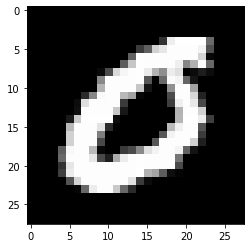

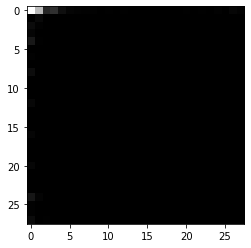

losses: 3.9227864742279053, 0.014363092370331287
losses: 5.446538925170898, 0.008662188425660133
losses: 6.742048263549805, 0.015382545068860054
losses: 7.543512344360352, 0.018319973722100258
losses: 7.6621551513671875, 0.008313266560435295
losses: 7.4473724365234375, 0.005188156850636005
losses: 6.998743534088135, 0.002675164956599474
losses: 6.477642059326172, 0.0014522997662425041
losses: 5.979926586151123, 0.0015809221658855677
losses: 5.5923871994018555, 0.0022264630533754826
losses: 5.374017715454102, 0.0025651270989328623
losses: 5.380867958068848, 0.0024759117513895035
losses: 5.608699798583984, 0.0019213727209717035
losses: 6.011850357055664, 0.0013148174621164799
losses: 6.516355991363525, 0.0009101213072426617
losses: 7.040152549743652, 0.0007987527642399073
losses: 7.537771701812744, 0.0005920855328440666
losses: 7.983597278594971, 0.0009440594003535807
losses: 8.33657455444336, 0.00029356410959735513
losses: 8.649137496948242, 0.002712058136239648


KeyboardInterrupt: 

In [429]:
for e in range(epochs):
    for idx, real_data in enumerate(data):
        gz = train_step(real_data)
        if idx  == 0:
            print(f'-------------------- {idx} --------------------')
            imshow(real_data[0])
            imshow(gz[0])